# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import nsfg
import first

Given a list of values, there are several ways to count the frequency of each value.

In [2]:
t = [1, 2, 2, 3, 5]

You can use a Python dictionary:

In [3]:
hist = {}
for x in t:
    hist[x] = hist.get(x, 0) + 1
    
hist

{1: 1, 2: 2, 3: 1, 5: 1}

You can use a `Counter` (which is a dictionary with additional methods):

In [4]:
from collections import Counter
counter = Counter(t)
counter

Counter({1: 1, 2: 2, 3: 1, 5: 1})

Or you can use the `Hist` object provided by `thinkstats2`:

In [6]:
import thinkstats2
hist = thinkstats2.Hist([1, 2, 2, 3, 5])
hist

Hist({1: 1, 2: 2, 3: 1, 5: 1})

`Hist` provides `Freq`, which looks up the frequency of a value.

In [7]:
hist.Freq(2)

2

You can also use the bracket operator, which does the same thing.

In [8]:
hist[2]

2

If the value does not appear, it has frequency 0.

In [9]:
hist[4]

0

The `Values` method returns the values:

In [10]:
hist.Values()

dict_keys([1, 2, 3, 5])

So you can iterate the values and their frequencies like this:

In [11]:
for val in sorted(hist.Values()):
    print(val, hist[val])

1 1
2 2
3 1
5 1


Or you can use the `Items` method:

In [12]:
for val, freq in hist.Items():
     print(val, freq)

1 1
2 2
3 1
5 1


`thinkplot` is a wrapper for `matplotlib` that provides functions that work with the objects in `thinkstats2`.

For example `Hist` plots the values and their frequencies as a bar graph.

`Config` takes parameters that label the x and y axes, among other things.

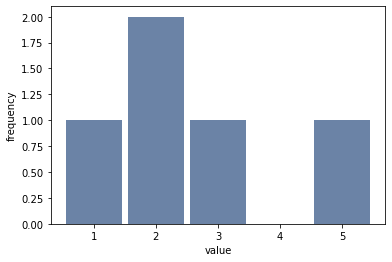

In [13]:
import thinkplot
thinkplot.Hist(hist)
thinkplot.Config(xlabel='value', ylabel='frequency')

As an example, I'll replicate some of the figures from the book.

First, I'll load the data from the pregnancy file and select the records for live births.

In [14]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]

Here's the histogram of birth weights in pounds.  Notice that `Hist` works with anything iterable, including a Pandas Series.  The `label` attribute appears in the legend when you plot the `Hist`. 

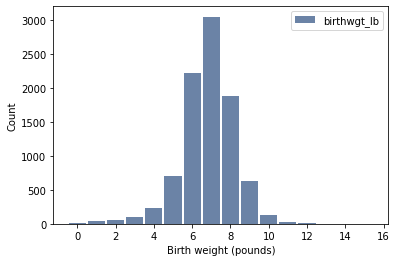

In [15]:
hist = thinkstats2.Hist(live.birthwgt_lb, label='birthwgt_lb')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='Count')

Before plotting the ages, I'll apply `floor` to round down:

In [16]:
ages = np.floor(live.agepreg)

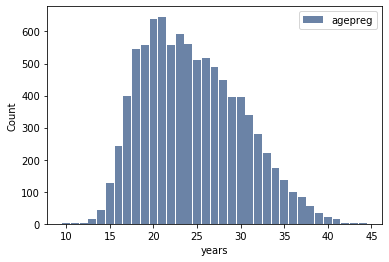

In [17]:
hist = thinkstats2.Hist(ages, label='agepreg')
thinkplot.Hist(hist)
thinkplot.Config(xlabel='years', ylabel='Count')

As an exercise, plot the histogram of pregnancy lengths (column `prglngth`).

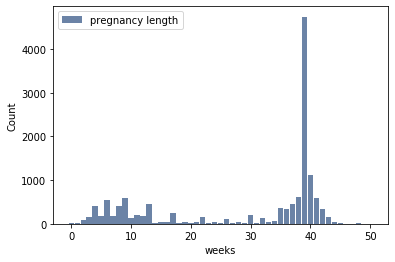

In [79]:
length = preg.prglngth
hist_length = thinkstats2.Hist(length, label='pregnancy length')
thinkplot.Hist(hist_length)
thinkplot.Config(xlabel='weeks', ylabel='Count')

`Hist` provides smallest, which select the lowest values and their frequencies.

In [80]:
for weeks, freq in hist.Smallest(10):
    print(weeks, freq)

10.0 2
11.0 1
12.0 1
13.0 14
14.0 43
15.0 128
16.0 242
17.0 398
18.0 546
19.0 559


Use `Largest` to display the longest pregnancy lengths.

In [81]:
print(hist_length.Largest(1))

[(50, 2)]


From live births, we can select first babies and others using `birthord`, then compute histograms of pregnancy length for the two groups.

In [30]:
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

first_hist = thinkstats2.Hist(firsts.prglngth, label='first')
other_hist = thinkstats2.Hist(others.prglngth, label='other')

We can use `width` and `align` to plot two histograms side-by-side.

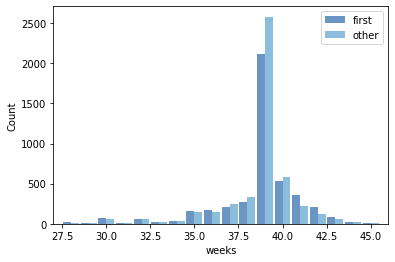

In [34]:
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(first_hist, align='right', width=width)
thinkplot.Hist(other_hist, align='left', width=width)
thinkplot.Config(xlabel='weeks', ylabel='Count', xlim=[27, 46])

`Series` provides methods to compute summary statistics:

### mean:
$$\bar{x} = \frac{1}{n}  \sum_{i}x_i$$

$n \to$ number of elements

### variance:

variability or spread of a distribution

variance for a **sample**:

$$S^2 = \frac{1}{n}  \sum_{i}(x_i - \bar{x})^2$$

variance in a **population** using a sample:

$$S^2 = \frac{1}{n-1}  \sum_{i}(x_i - \bar{x})^2$$

$S^2 \to$ standard deviation

$(x_i - \bar{x}) \to$ deviation from the mean

### standard deviation

$$S = \sqrt{\frac{1}{n}  \sum_{i}(x_i - \bar{x})^2}$$

In [37]:
mean = live.prglngth.mean()
var = live.prglngth.var()
std = live.prglngth.std()

Here are the mean and standard deviation:

In [23]:
mean, std

(38.56055968517709, 2.702343810070587)

As an exercise, confirm that `std` is the square root of `var`:

In [40]:
var**(1/2) == std

True

Here's are the mean pregnancy lengths for first babies and others:

In [42]:
firsts.prglngth.mean(), others.prglngth.mean()

(38.60095173351461, 38.52291446673706)

And here's the difference (in weeks):

In [41]:
firsts.prglngth.mean() - others.prglngth.mean()

0.07803726677754952

This functon computes the **Cohen effect size**, which is the difference in means expressed in number of standard deviations:

$$d= \frac{\bar{x_1} - \bar{x_2}}{s}$$

$\bar{x_1}$ and $\bar{x_1}$ are the means of the group

$s$ is the pooled standard deviation

In [44]:
def CohenEffectSize(group1, group2):
    """Computes Cohen's effect size for two groups.
    
    group1: Series or DataFrame
    group2: Series or DataFrame
    
    returns: float if the arguments are Series;
             Series if the arguments are DataFrames
    """
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

Compute the Cohen effect size for the difference in pregnancy length for first babies and others.

In [48]:
CohenEffectSize(firsts.prglngth, others.prglngth)

0.028879044654449834

>The difference in means is 0.029 standar deviations, wich is small.

## Exercises

_Using the variable `totalwgt_lb`, investigate whether first babies are lighter or heavier than others._ 

They seems to be ligther on average.

_Compute Cohen’s effect size to quantify the difference between the groups.  How does it compare to the difference in pregnancy length?_

there is a slightly greater difference, but still pretty low.

In [49]:
firsts.totalwgt_lb.mean() - others.totalwgt_lb.mean()

-0.12476118453549034

In [50]:
CohenEffectSize(firsts.totalwgt_lb, others.totalwgt_lb)

-0.08867292707260174

For the next few exercises, we'll load the respondent file:

In [62]:
resp = nsfg.ReadFemResp()

Make a histogram of <tt>totincr</tt> the total income for the respondent's family.  To interpret the codes see the [codebook](http://www.icpsr.umich.edu/nsfg6/Controller?displayPage=labelDetails&fileCode=FEM&section=R&subSec=7876&srtLabel=607543).

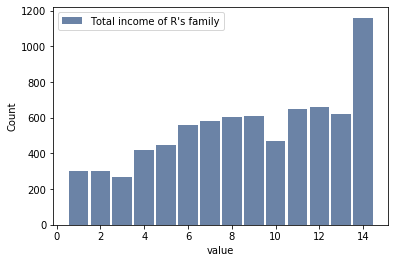

In [69]:
toincome = resp.totincr
hist_income = thinkstats2.Hist(toincome, label="Total income of R's family")
thinkplot.Hist(hist_income)
thinkplot.Config(xlabel='value', ylabel='Count')

Make a histogram of <tt>age_r</tt>, the respondent's age at the time of interview.

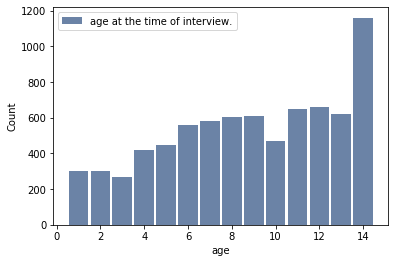

In [70]:
age = resp.age_r
hist_age = thinkstats2.Hist(toincome, label="age at the time of interview.")
thinkplot.Hist(hist_age)
thinkplot.Config(xlabel='age', ylabel='Count')

Make a histogram of <tt>numfmhh</tt>, the number of people in the respondent's household.

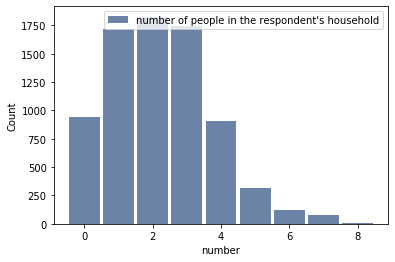

In [71]:
num_household = resp.numfmhh
hist_num_house = thinkstats2.Hist(num_household, label="number of people in the respondent's household")
thinkplot.Hist(hist_num_house)
thinkplot.Config(xlabel='number', ylabel='Count')

_Make a histogram of <tt>parity</tt>, the number of children borne by the respondent.  How would you describe this distribution?_

Right Skewed distribution

Most respondents have between 0 and 2 children

Unimodal

With the presence of extreme outliers, such as 22 children

count    7643.000000
mean        1.223211
std         1.389722
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        22.000000
Name: parity, dtype: float64


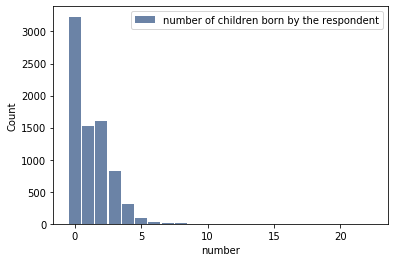

In [75]:
child_born = resp.parity
hist_born = thinkstats2.Hist(child_born, label="number of children born by the respondent")
thinkplot.Hist(hist_born)
thinkplot.Config(xlabel='number', ylabel='Count')
print(child_born.describe())

Use Hist.Largest to find the largest values of <tt>parity</tt>.

In [84]:
hist_born.Largest(1)

[(22, 1)]

Let's investigate whether people with higher income have higher parity.  Keep in mind that in this study, we are observing different people at different times during their lives, so this data is not the best choice for answering this question.  But for now let's take it at face value.

Use <tt>totincr</tt> to select the respondents with the highest income (level 14).  Plot the histogram of <tt>parity</tt> for just the high income respondents.

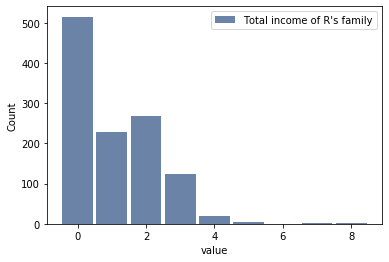

In [87]:
wealth = resp[resp.totincr == 14]
wealth_parity = wealth.parity
hist_wparity = thinkstats2.Hist(wealth_parity, label="Total income of R's family")
thinkplot.Hist(hist_wparity)
thinkplot.Config(xlabel='value', ylabel='Count')

Find the largest parities for high income respondents.

In [88]:
hist_wparity.Largest(1)

[(8, 1)]

Compare the mean <tt>parity</tt> for high income respondents and others.

In [94]:
wealth = resp[resp.totincr == 14]
otherinc = resp[resp.totincr != 14]
print('Mean of wealth {} and Mean of others {}'.format(wealth.parity.mean(), otherinc.parity.mean()))
print(wealth.parity.mean() - otherinc.parity.mean())

Mean of wealth 1.0758620689655172 and Mean of others 1.2495758136665125
-0.17371374470099532


___Compute the Cohen effect size for this difference.  How does it compare with the difference in pregnancy length for first babies and others?___

The differnce is of 0.12 std, much higher then the difference between pregnancy lengths. The correlation is much more proeminent.

In [95]:
print(CohenEffectSize(wealth.parity, otherinc.parity))

-0.12511855314660367
